In this notebook, we will walk through the major observation of the paper, using EDM pretrained models as exampls
* The learned neural denoising function can be well approximated by a linear denoising function, which is the Gaussian score denoiser. 
* The Gaussian score allows for an analytical sampling trajectory, which approximates the neural one for a long time. 
* This approximation can be used to analytically teleport sampling.  

In [1]:
import os
from os.path import join
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm, trange
import pickle   
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

device = "cuda" if torch.cuda.is_available() else "cpu"

### Utility function

In [2]:
def tsr_to_mtg(tsr, nrow=8, padding=2):
    images_actual = (tsr * 127.5 + 128).clip(0, 255).to(torch.uint8)
    return ToPILImage()(make_grid(images_actual, nrow=nrow, padding=padding))


### Sampler function using analytical solution

In [3]:
def gaussian_analytical_x_t_solution_edm(xT, mu, U, Lambda, sigma_ts, sigma_T=None):
    """ Compute the analytical trajectory of x_t for a given initial condition x_T

    Args:
        xT: B x ndim tensor, a batch of initial conditions
        sigma_ts: Tdim, noise level / time discretization steps
        mu: ndim, mean of the Gaussian distribution
        U: ndim x rdim, eigenvectors of the covariance matrix
        Lambda: rdim, eigenvalues of the covariance matrix

    Returns:
        xt_traj: Tdim x B x ndim, the trajectory of x_t

    edm_x_t_traj(torch.randn(2, 100), torch.randn(100), torch.randn(100, 10), torch.rand(10), torch.arange(10)).shape
    edm_x_t_traj(torch.randn(2, 100), torch.randn(100), torch.randn(100, 100), torch.rand(100), torch.arange(10)).shape

    """
    if sigma_T is None:
        sigma_T = sigma_ts.max()
    xT_rel = xT - mu[None, :]  # B x ndim
    xT_coef = xT_rel @ U  # B x rdim
    if U.shape[1] < U.shape[0]:
        # when the number of eigenvectors is less than the dimension of the data (low-rank PCA)
        xT_residue = xT_rel - xT_coef @ U.T  # B x ndim
    else:
        xT_residue = None
    scaling_coef = torch.sqrt(sigma_ts[None, :] ** 2 + Lambda[:, None])  # rdim x Tdim
    scaling_coef = scaling_coef / torch.sqrt(sigma_T ** 2 + Lambda)[:, None]  # rdim x Tdim
    xt_scaled_coef = torch.einsum('br,rT->Tbr', xT_coef, scaling_coef)  # Tdim x B x rdim
    xt_traj_onmanif = torch.einsum('Tbr,rn->Tbn', xt_scaled_coef, U.T)  # Tdim x B x ndim
    if xT_residue is not None:
        residue_scaling = sigma_ts / sigma_T  # Tdim
        residue_traj = torch.einsum('bn,T->Tbn', xT_residue, residue_scaling, )  # B x Tdim x ndim
        xt_traj = residue_traj + xt_traj_onmanif + mu[None, None, ]  # B x Tdim x ndim
    else:
        xt_traj = xt_traj_onmanif + mu[None, None, ]
    return xt_traj


def gaussian_analytical_x0hat_t_solution_edm(xT, mu, U, Lambda, sigma_ts, sigma_T=None):
    """ Compute the analytical trajectory of x0_hat for a given initial condition x_T
    """
    if sigma_T is None:
        sigma_T = sigma_ts.max()
    xT_rel = xT - mu[None, :]  # B x ndim
    xT_coef = xT_rel @ U  # B x rdim
    # if U.shape[1] < U.shape[0]:
    #     # when the number of eigenvectors is less than the dimension of the data (low-rank PCA)
    #     xT_residue = xT_rel - xT_coef @ U.T  # B x ndim
    # else:
    #     xT_residue = None
    scaling_coef = Lambda[:, None] / torch.sqrt(sigma_T ** 2 + Lambda)[:, None] / torch.sqrt(sigma_ts[None, :] ** 2 + Lambda[:, None]) # rdim x Tdim
    x0hat_t_scaled_coef = torch.einsum('br,rT->Tbr', xT_coef, scaling_coef)  # Tdim x B x rdim
    x0hat_t_traj_onmanif = torch.einsum('Tbr,rn->Tbn', x0hat_t_scaled_coef, U.T)  # Tdim x B x ndim
    # if xT_residue is not None:
    #     residue_scaling = sigma_ts / sigma_T  # Tdim
    #     residue_traj = torch.einsum('bn,T->Tbn', xT_residue, residue_scaling, )  # B x Tdim x ndim
    #     x0hat_traj = residue_traj + x0hat_t_traj_onmanif + mu[None, None, ]  # B x Tdim x ndim
    # else:
    x0hat_traj = x0hat_t_traj_onmanif + mu[None, None, ]
    return x0hat_traj


def edm_sampler_return(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    """
    Heun's Sampling function from EDM, adapted to return the trajectory of x_t and denoised x_t
    """
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_traj = []
    denoised_traj = []
    x_next = latents.to(torch.float64) * t_steps[0]
    x_traj.append(x_next.detach().clone())
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, math.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

        x_traj.append(x_next.detach().clone())
        denoised_traj.append(denoised.detach().clone())

    return x_next, t_steps, x_traj, denoised_traj



### Download UNet checkpoint and PCA data

In [4]:
import os
import urllib.request
def download_edm_model(dataset_name, ckpt_dir):
    ckpt_url = {"cifar32": "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-vp.pkl",
                "ffhq64": "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-ffhq-64x64-uncond-vp.pkl",
                "afhq64": "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-afhqv2-64x64-uncond-vp.pkl"}[dataset_name]
    ckpt_filename = os.path.join(ckpt_dir, os.path.basename(ckpt_url))
    if not os.path.exists(ckpt_filename):
        urllib.request.urlretrieve(ckpt_url, ckpt_filename)
        print(f"Downloaded EDM model file {ckpt_filename}")
    else:
        print(f"EDM model file {ckpt_filename} already exists, skipping download")
    return ckpt_filename
    
    
def download_dataset_pca(dataset_name, PCA_dir):
    PCA_url = {"cifar32": "https://huggingface.co/datasets/binxu/image_datasets_PCAs/resolve/main/cifar32_PCA.pt",
                "ffhq64": "https://huggingface.co/datasets/binxu/image_datasets_PCAs/resolve/main/ffhq64_PCA.pt",
                "afhq64": "https://huggingface.co/datasets/binxu/image_datasets_PCAs/resolve/main/afhqv264_PCA.pt",
                "imagenet64": "https://huggingface.co/datasets/binxu/image_datasets_PCAs/resolve/main/imagenet64_PCA.pt"}[dataset_name]
    PCA_filename = os.path.join(PCA_dir, os.path.basename(PCA_url))
    if not os.path.exists(PCA_filename):
        try:
            from huggingface_hub import hf_hub_download
            hf_file_path = hf_hub_download(repo_id="binxu/image_datasets_PCAs", repo_type="dataset",
                               filename=os.path.basename(PCA_url), local_dir=PCA_dir)
        except:
            print(f"Failed to use huggingface_hub, using urllib to download PCA file {PCA_filename}")
            urllib.request.urlretrieve(PCA_url, PCA_filename)
        print(f"Downloaded PCA file {PCA_filename}")
    else:
        print(f"PCA file {PCA_filename} already exists, skipping download")
    return PCA_filename


def download_dataset_pca_all(ckpt_dir, PCA_dir, dataset_names=("cifar32", "ffhq64", "afhq64", "imagenet64")):
    for dataset_name in dataset_names:
        download_dataset_pca(dataset_name, PCA_dir)
        download_edm_model(dataset_name, ckpt_dir)
    return ckpt_dir, PCA_dir

In [5]:
ckpt_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/edm_ckpts_tmp"
PCA_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/imgdataset_PCAs_tmp"
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(PCA_dir, exist_ok=True)

download_dataset_pca_all(ckpt_dir, PCA_dir, dataset_names=("cifar32", "ffhq64", "afhq64",))

PCA file /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/imgdataset_PCAs_tmp/cifar32_PCA.pt already exists, skipping download
EDM model file /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/edm_ckpts_tmp/edm-cifar10-32x32-uncond-vp.pkl already exists, skipping download
PCA file /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/imgdataset_PCAs_tmp/ffhq64_PCA.pt already exists, skipping download
EDM model file /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/edm_ckpts_tmp/edm-ffhq-64x64-uncond-vp.pkl already exists, skipping download
PCA file /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/imgdataset_PCAs_tmp/afhqv264_PCA.pt already exists, skipping download
EDM model file /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/edm_ckpts_tmp/edm-afhqv2-64x64-uncond-vp.pkl already exists, skipping download

('/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/edm_ckpts_tmp',
 '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/imgdataset_PCAs_tmp')

In [6]:
import sys
sys.path.append("/n/home12/binxuwang/Github/edm")
# sys.path.append("/n/home12/binxuwang/Github/GaussianTeleportationDiffusion/gaussian_teleport/edm")

In [7]:
ckpt_name_dict = {"cifar32": "edm-cifar10-32x32-uncond-vp.pkl",
                 "ffhq64": "edm-ffhq-64x64-uncond-vp.pkl",
                 "afhq64": "edm-afhqv2-64x64-uncond-vp.pkl",}
PCA_name_dict = {"cifar32": "cifar32_PCA.pt",
                 "ffhq64": "ffhq64_PCA.pt",
                 "afhq64": "afhqv264_PCA.pt",
                 "imagenet64": "imagenet64_PCA.pt"}

dataset_name = "ffhq64" # choose from "cifar32", "ffhq64", "afhq64", "imagenet64"
PCA_name = PCA_name_dict[dataset_name]
ckpt_name = ckpt_name_dict[dataset_name]

network_pkl = join(ckpt_dir, ckpt_name)
net = pickle.load(open(network_pkl, 'rb'))['ema'].to(device)
data = torch.load(join(PCA_dir, PCA_name))  # load covariance and mean of the dataset
# default normalization
norm_mean, norm_std = 0.5, 0.5
cov_eigs, eigvecs, imgmean  = data["eigval"], data["eigvec"], data["imgmean"]
eigvecs = eigvecs.to(device)
imgmean = imgmean.to(device)
cov_eigs = cov_eigs.to(device)
# compute image mean and covariance in normalized space 
# imgmean_norm = (imgmean - norm_mean) / norm_std
# cov_eigs_norm = cov_eigs / norm_std**2
imgmean_norm = imgmean * 2 - 1
cov_eigs_norm = cov_eigs * 4

### Score comparison

In [8]:
sys.path.append("/n/home12/binxuwang/Github/GaussianTeleportationDiffusion")
from gaussian_teleport.gmm_general_diffusion_lib import \
    gaussian_mixture_score_torch, deltaGMM_scores_torch_batch, \
    gaussian_score_torch, deltaGMM_scores_torch 

In [10]:
sigma = 2.0
batch_seeds = 42
batch_size = 512
img_shape = (net.img_channels, net.img_resolution, net.img_resolution)
latents = torch.randn([batch_size, *img_shape], 
                      device=device, 
                      generator=torch.Generator(device=device).manual_seed(batch_seeds))
sigma_t = torch.tensor(sigma, device=device, dtype=torch.float64)
x_probe = latents * sigma_t
x_probe_flatten = x_probe.flatten(1)
# compute score of the data distribution with EDM 
denoiser_edm = net(x_probe, sigma_t, None)
score_edm = (denoiser_edm - x_probe) / sigma_t ** 2
score_edm_vec = score_edm.flatten(1)
denoiser_edm_vec = denoiser_edm.flatten(1)
# compute score of the Gaussian distribution
score_gauss = gaussian_mixture_score_torch(x_probe_flatten, 
                            imgmean_norm[None], eigvecs[None],
                            cov_eigs[None] + sigma_t ** 2)
denoiser_gauss = x_probe_flatten + sigma_t ** 2 * score_gauss
# # 'gmm': gaussian_mixture_score_torch(x_probe_flatten, mu_cls, U_cls, Lambda_cls + sigma ** 2),
# 'delta': deltaGMM_scores_torch_batch(xarr_all, sigma_t, x_probe_flatten, device="cuda", batch_size=4).cuda(),
MSE_score = ((score_edm_vec - score_gauss) ** 2).mean(dim=1)
MS_score = ((score_edm_vec) ** 2).mean(dim=1)
err_frac_score = MSE_score / MS_score

MSE_denoiser = ((denoiser_edm_vec - denoiser_gauss) ** 2).mean(dim=1)
MS_denoiser = ((denoiser_edm_vec) ** 2).mean(dim=1)
err_frac_denoiser = MSE_denoiser / MS_denoiser
print(f"Sigma: {sigma:.3f} | Batch size: {batch_size}, Seed: {batch_seeds}")
print(f"Score MSE - Mean: {MSE_score.mean():.1e}, q25%: {MSE_score.quantile(0.25):.1e}, q75%: {MSE_score.quantile(0.75):.1e}")
print(f"Score MSE err fraction - Mean: {err_frac_score.mean():.1e}, q25%: {err_frac_score.quantile(0.25):.1e}, q75%: {err_frac_score.quantile(0.75):.1e}")
print(f"Denoiser MSE - Mean: {MSE_denoiser.mean():.1e}, q25%: {MSE_denoiser.quantile(0.25):.1e}, q75%: {MSE_denoiser.quantile(0.75):.1e}")
print(f"Denoiser MSE err fraction - Mean: {err_frac_denoiser.mean():.1e}, q25%: {err_frac_denoiser.quantile(0.25):.1e}, q75%: {err_frac_denoiser.quantile(0.75):.1e}")

Sigma: 2.000 | Batch size: 512, Seed: 42
Score MSE - Mean: 1.6e-04, q25%: 1.3e-04, q75%: 1.7e-04
Score MSE err fraction - Mean: 6.2e-04, q25%: 5.1e-04, q75%: 7.0e-04
Denoiser MSE - Mean: 2.5e-03, q25%: 2.1e-03, q75%: 2.8e-03
Denoiser MSE err fraction - Mean: 3.5e-01, q25%: 2.5e-01, q75%: 4.2e-01


### Gaussian Analytical vs EDM Neural sampling trajectory 

In [11]:
batch_size = 8
batch_seeds = 40
img_shape = (net.img_channels, net.img_resolution, net.img_resolution)

num_steps = 35
sigma_min = 0.002
sigma_max = 80
rho = 7
# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)
# Time step discretization.
step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) 

latents = torch.randn([batch_size, *img_shape], device=device, generator=torch.Generator(device=device).manual_seed(batch_seeds))
xT_vecs = latents.flatten(1) * t_steps[0]

x_traj_analy = gaussian_analytical_x_t_solution_edm(xT_vecs, imgmean_norm.flatten(), eigvecs, cov_eigs_norm,
                            t_steps.float(), sigma_T=t_steps[0].float())
x0hat_traj_analy = gaussian_analytical_x0hat_t_solution_edm(xT_vecs, imgmean_norm.flatten(), eigvecs, cov_eigs_norm,
                            t_steps.float(), sigma_T=t_steps[0].float())
samples_edm, _, x_traj_edm, x0hat_traj_edm = edm_sampler_return(net, latents, class_labels=None,
                                randn_like=torch.randn_like, sigma_min=sigma_min, sigma_max=sigma_max, rho=rho, num_steps=num_steps)

x_traj_edm = torch.stack(x_traj_edm, dim=0)
x0hat_traj_edm = torch.stack(x0hat_traj_edm, dim=0)
x_traj_analy_imgs = x_traj_analy.reshape(*x_traj_analy.shape[:2], *img_shape)
x0hat_traj_analy_imgs = x0hat_traj_analy.reshape(*x0hat_traj_analy.shape[:2], *img_shape)

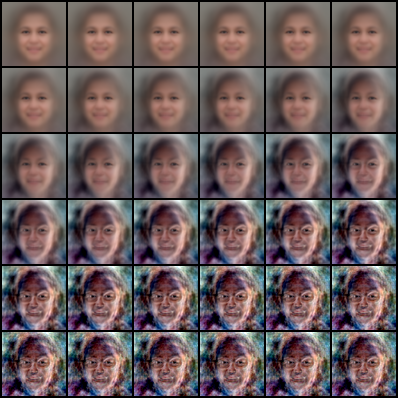

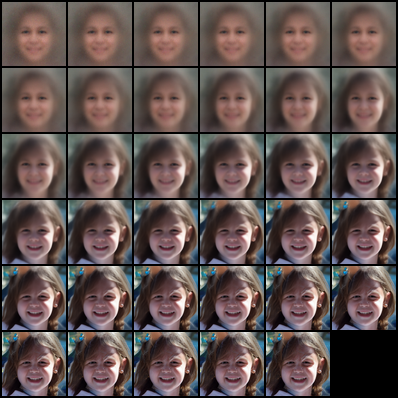

In [12]:
sample_id = 5
mtg_analy = tsr_to_mtg(x0hat_traj_analy_imgs[:, sample_id], nrow=6, padding=2)
display(mtg_analy)
mtg_edm = tsr_to_mtg(x0hat_traj_edm[:, sample_id], nrow=6, padding=2)
display(mtg_edm)

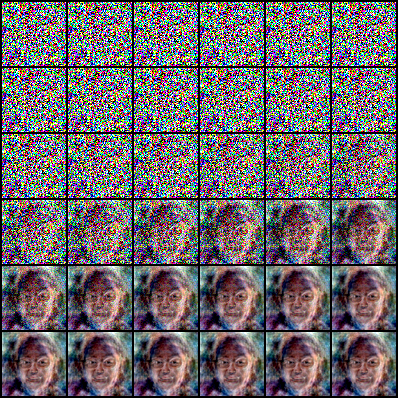

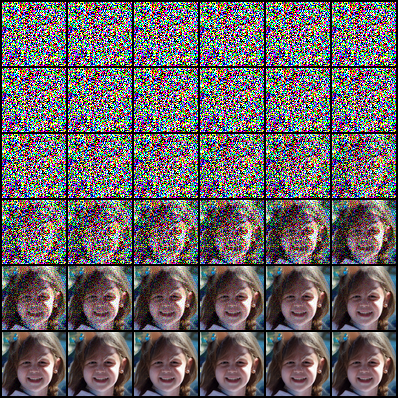

In [13]:
sample_id = 5
mtg_analy = tsr_to_mtg(x_traj_analy_imgs[:, sample_id], nrow=6, padding=2)
display(mtg_analy)
mtg_edm = tsr_to_mtg(x_traj_edm[:, sample_id], nrow=6, padding=2)
display(mtg_edm)

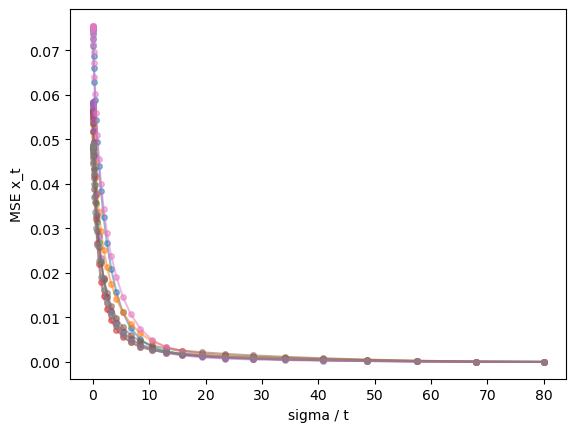

In [17]:
# compute MSE
mse_edm = ((x_traj_analy_imgs - x_traj_edm) ** 2).mean(dim=(2,3,4))
plt.plot(t_steps.cpu().numpy(), mse_edm.cpu().numpy(), '-o', markersize=4, alpha=0.5)
plt.ylabel("MSE x_t")
plt.xlabel("sigma / t")
# plt.xscale("log")
# plt.yscale("log")
plt.show()

### AnalyticalTeleportation: Comparison of sampling with different skipping steps

In [18]:
img_shape = (net.img_channels, net.img_resolution, net.img_resolution)

skipstep_list = [0, 1, 2, 4, 6, 8, 9, 10, 11, 12]
skip_images_col = {}
# sampling 
batch_seeds = 42
batch_size = 32

num_steps = 18
sigma_min = 0.002
sigma_max = 80
rho = 7
# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)
# Time step discretization.
step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) 

latents = torch.randn([batch_size, *img_shape], device=device, generator=torch.Generator(device=device).manual_seed(batch_seeds))
xT_vecs = latents.flatten(1) * t_steps[0]
x_traj_analy = gaussian_analytical_x_t_solution_edm(xT_vecs, imgmean_norm.flatten(), eigvecs, cov_eigs_norm,
                            t_steps.float(), sigma_T=t_steps[0].float())
for skipstep in skipstep_list: 
    sigma_max_skip = t_steps[skipstep]
    skip_kwargs = dict(sigma_min=0.002, sigma_max=sigma_max_skip, rho=7, num_steps=num_steps - skipstep)
    print(f"skipstep={skipstep}, skip to sigma_max={sigma_max_skip:.3f}, NFE={skip_kwargs['num_steps'] * 2 - 1}")
    skip_latents = x_traj_analy[skipstep].reshape(batch_size, *img_shape)
    skip_latents = skip_latents / sigma_max_skip
    skip_images, _, _, _ = edm_sampler_return(net, skip_latents, class_labels=None,
                                        randn_like=torch.randn_like, **skip_kwargs)
    skip_images_col[skipstep] = skip_images
    
skip_images_tsr = torch.stack(list(skip_images_col.values()), dim=0)

skipstep=0, skip to sigma_max=80.000, NFE=35
skipstep=1, skip to sigma_max=57.586, NFE=33
skipstep=2, skip to sigma_max=40.786, NFE=31
skipstep=4, skip to sigma_max=19.352, NFE=27
skipstep=6, skip to sigma_max=8.401, NFE=23
skipstep=8, skip to sigma_max=3.257, NFE=19
skipstep=9, skip to sigma_max=1.923, NFE=17
skipstep=10, skip to sigma_max=1.088, NFE=15
skipstep=11, skip to sigma_max=0.585, NFE=13
skipstep=12, skip to sigma_max=0.296, NFE=11


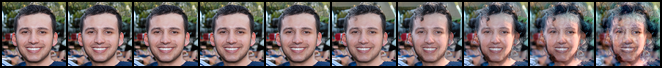

In [19]:
sample_id = 5
image_row = skip_images_tsr[:, sample_id]
mtg1 = tsr_to_mtg(image_row, nrow=skip_images_tsr.shape[0], padding=2)
display(mtg1)

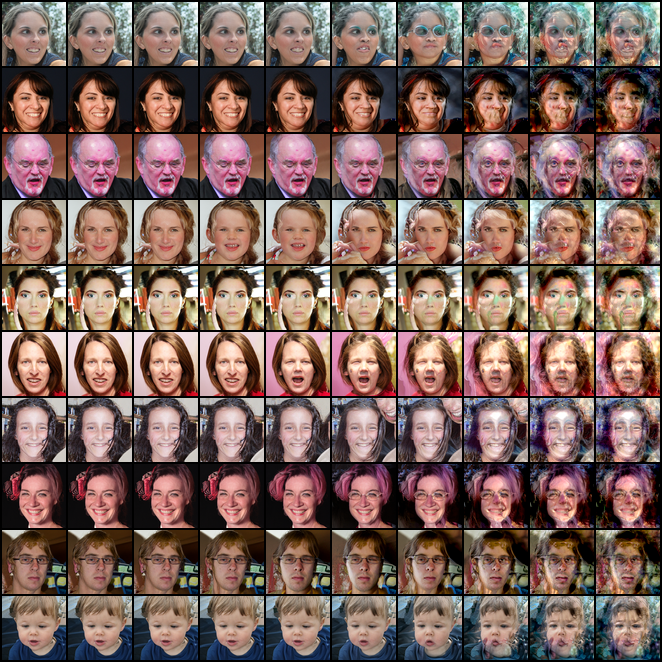

In [20]:
sample_ids = range(10, 20)
image_page = skip_images_tsr[:, sample_ids].transpose(1, 0).reshape(-1, *skip_images_tsr.shape[2:])
mtg1 = tsr_to_mtg(image_page, nrow=skip_images_tsr.shape[0], padding=2)
display(mtg1)